# Construção de cenários com simulação de Monte Carlo

## Introdução
Decisões que envolvem algum nível de risco exigem a criação de cenários, que fazemos muitas vezes sem perceber, do que é mais provável que aconteça em um futuro mensurável. A criações desses cenários influenciam diretamente as decisões tomadas, e por este motivo a sua contrução de maneira rigorosa colabora para melhorar ganhos ou minimizar prejuízos.

Normalmente criamos os cenários com os conceitos já pré-concebidos de toda a nossa carga cultural, informação que obtemos durante toda a vida e meio onde vivemos, portanto, todo cenário criado tende a ter algum tipo de viés. Para reduzir essa influência nas estimativas recorre-se a técnicas estatísticas e fatos prévios que podem ter algum efeito no que desejamos analisar.

Construir um cenário consiste em mensurar as situações mais prováveis em um futuro "próximo" mantendo todas as propriedades e informações relevantes da variável, e então analisar os riscos envolvidos. Para isso, o método de simulações de Monte Carlo pode ser uma ferramenta excelente nessa tarefa. 

O método de Monte Carlo cria simulações de vários processos aleatórios, dos quais possuem as mesmas características que a variável analisada. Com isso, é possível ter uma visão eficiente de situações prováveis no período planejado.

A finalidade deste artigo é, principalmente, demonstrar a utilização do método em um problema real de maneira que possa ser replicado. E a finalidade secundária é construir cenários para o índice da Bolsa de Valores, o Ibovespa, utilizando simulações de Monte Carlo com o Python a fim de fornecer informações relevantes para a tomada de decisão em investimentos.

## Ibovespa e Estatísticas Descritivas
O primeiro passo é carregar pacotes, baixar e tratar os dados.

In [2]:
# Carregando Pacotes
import pandas as pd
import numpy as np
import pandas_datareader as pnd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as st

# Coletando índice do Ibovespa
ibov = pnd.get_data_yahoo("^BVSP", start = '01-01-2010')
ibov.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-21,99057.00,97088.000000,98286.000000,99033.0,10060000.0,99033.0
2022-07-22,99724.00,98321.000000,99034.000000,98925.0,10033500.0,98925.0
2022-07-25,100508.00,98925.000000,98926.000000,100270.0,8621800.0,100270.0
2022-07-26,100753.00,99365.000000,100270.000000,99772.0,9136600.0,99772.0
2022-07-27,100533.25,99771.546875,99773.039062,100381.5,0.0,100381.5


Por meio do código acima obtemos os dados do Índice da Bovespa desde primeiro de Janeiro de 2010 até a observação mais recente. O dataframe, ou tabela de dados, tem informações sobre a performance no respectivo dia, mas para fins da nossa análise utilizamos apenas o fechamento.

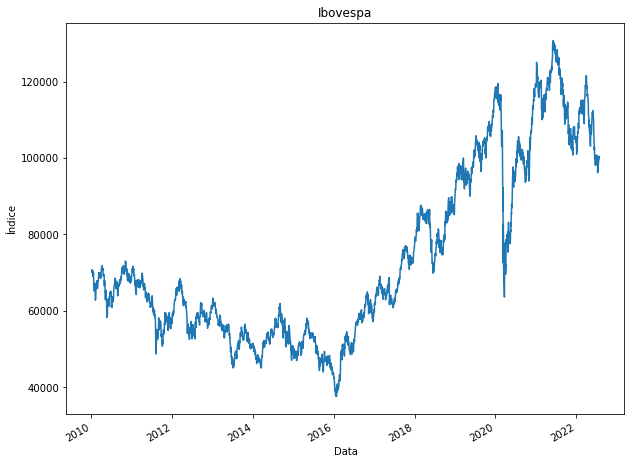

In [5]:
# Constuindo gráfico do índice
ibov["Close"].plot(figsize = (10,8))
plt.title('Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Data')
plt.show()

Para remover a tendência e tornar a análise mais robusta, calculamos os retornos diários do Ibovespa no período analisado.

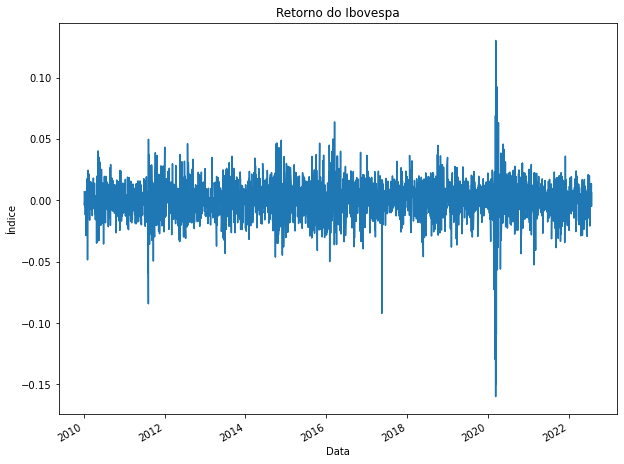

In [6]:
# Calculando os retornos diários
ibov['Return'] = np.log(ibov.Close)-np.log(ibov.Close.shift(1))
ibov = ibov.iloc[2:]
ibov["Return"].plot(figsize = (10,8))
plt.title('Retorno do Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Data')
plt.show()

A partir do gráfico acima podemos notar que os retornos seguem relativamente constantes ao longo dos anos, e com períodos de maior variação (maior risco) em momentos de instabilidade econômica, como por exemplo no início de 2020 em função da crise do Covid-19.

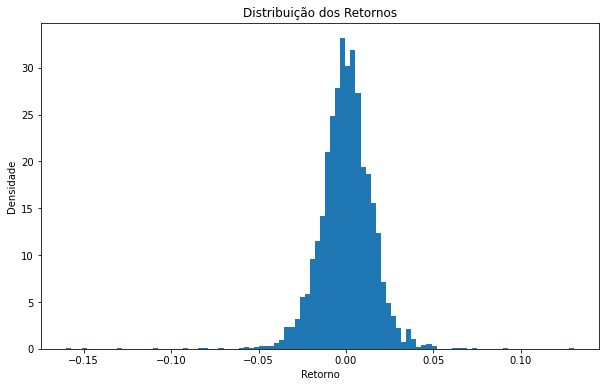

count    3107.000000
mean        0.000115
std         0.015582
min        -0.159930
25%        -0.008210
50%         0.000280
75%         0.008848
max         0.130223
Name: Return, dtype: float64


In [28]:
# Estatísticas Descritivas
fig, graf = plt.subplots(figsize=(10,6))
graf.hist(ibov['Return'], density=True, histtype='stepfilled', bins = 100, label='Densidade do retorno')
graf.set_title('Distribuição dos Retornos')
graf.set_ylabel('Densidade')
graf.set_xlabel('Retorno')
plt.show()
print(ibov.Return.describe())

Através da análise descritiva conseguimos observar que os retornos diários históricos se concentram principalmente entre 5% e -5%. A média diária dos retornos é de 0,0115% e o desvio padrão é de 1,5% aproximadamente.

## Simulação de Monte Carlo
Para realizar as simulações, é necessário ter um conhecimento prévio sobre a distribuição da variável analisada, neste caso é os retornos diários. Como não sabemos qual a distribuição da variável, realizamos o teste de Kolmogorov-Smirnov entre as principais distribuição teórica contínuas a fim de identificar a que mais se assemelha.

In [14]:
# Seleção da melhor distribuição
import warnings
warnings.filterwarnings('ignore')
def melhor_dist(dado):
    dist_names = ['alpha' ,'anglit' ,'arcsine' ,'argus' ,'beta' ,'betaprime' ,'bradford' ,'burr' ,'burr12' ,'cauchy' ,'chi' ,'chi2' ,'cosine' ,'crystalball' ,'dgamma' ,'dweibull' ,'erlang' ,'expon' ,'exponnorm' ,'exponweib' ,'exponpow' ,'f' ,'fatiguelife' ,'fisk' ,'foldcauchy' ,'foldnorm' ,'genlogistic' ,'gennorm' ,'genpareto' ,'genexpon' ,'genextreme' ,'gausshyper' ,'gamma' ,'gengamma' ,'genhalflogistic' ,'genhyperbolic' ,'geninvgauss' ,'gilbrat' ,'gompertz' ,'gumbel_r' ,'gumbel_l' ,'halfcauchy' ,'halflogistic' ,'halfnorm' ,'halfgennorm' ,'hypsecant' ,'invgamma' ,'invgauss' ,'invweibull' ,'johnsonsb' ,'johnsonsu' ,'kappa4' ,'kappa3' ,'ksone' ,'kstwobign' ,'laplace' ,'laplace_asymmetric' ,'levy' ,'levy_l' ,'logistic' ,'loggamma' ,'loglaplace' ,'lognorm' ,'loguniform' ,'lomax' ,'maxwell' ,'mielke' ,'moyal' ,'nakagami' ,'ncx2' ,'ncf' ,'nct' ,'norm' ,'norminvgauss' ,'pareto' ,'pearson3' ,'powerlaw' ,'powerlognorm' ,'powernorm' ,'rdist' ,'rayleigh' ,'rice' ,'recipinvgauss' ,'semicircular' ,'skewcauchy' ,'skewnorm' ,'t' ,'trapezoid' ,'triang' ,'truncexpon' ,'truncnorm' ,'tukeylambda' ,'uniform' ,'vonmises' ,'vonmises_line' ,'wald' ,'weibull_min' ,'weibull_max' ,'wrapcauchy']
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(dado)
        params[dist_name] = param

        # Aplicando teste Kolmogorov-Smirnov
        D, p = st.kstest(dado, dist_name, args=param)
        dist_results.append((dist_name, p))
    
    # Selecionando melhor distribuição
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))

    print("A melhor distribuição: "+str(best_dist))
    print("Melhor p valor: "+ str(best_p))
    print("Parâmetros: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

melhor_dist(ibov['Return'])

A melhor distribuição: t
Melhor p valor: 0.9121989651578579
Parâmetros: (4.98623200129248, 0.0003429510366358815, 0.011656276430448123)


('t',
 0.9121989651578579,
 (4.98623200129248, 0.0003429510366358815, 0.011656276430448123))

De acordo com o teste conduzido, não se pode rejeitar a hipótese nula de que os retornos do ibovespa tem distribuição t (p valor: 0,9122), cujos parâmetros estão descritos acima. Podemos ver graficamente a similaridade da distribuição.

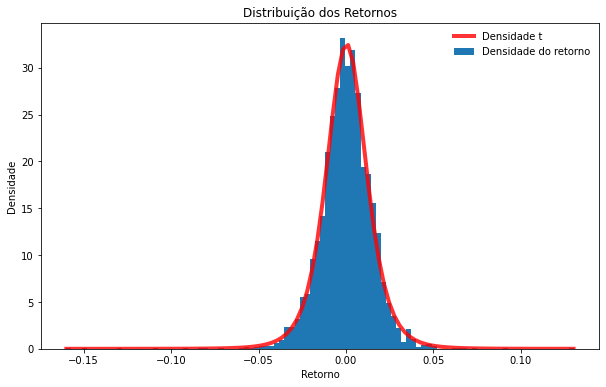

In [15]:
# Analisando similaridade
from scipy.stats import t
dist = getattr(st, 't')
param = dist.fit(ibov['Return'])
x = np.linspace(np.percentile(ibov['Return'],0), np.percentile(ibov['Return'],100), 100)
fig, graf = plt.subplots(figsize=(10,6))
graf.plot(x, t.pdf(x, df = param[0], loc = param[1], scale = param[2]),'red', lw=4, alpha = 0.8, label='Densidade t')
graf.hist(ibov['Return'], density=True, histtype='stepfilled', bins = 100, label='Densidade do retorno')
graf.legend(loc='best', frameon=False)
graf.set_title('Distribuição dos Retornos')
graf.set_ylabel('Densidade')
graf.set_xlabel('Retorno')
plt.show()

Sob a hipótese de que os retornos segue distribuição t, podemos criar simulações com amostras aleatórias dos retornos. Será desenvolvida 100 mil simulações dos retornos para um período de um ano. Então, a partir da sequência aleatória do retorno em todas as simulações, calcula-se o índice no período seguindo a respectiva variação para todas as amostras. Podemos ver a seguir uma amostra das simulações estimadas.

<function matplotlib.pyplot.show(close=None, block=None)>

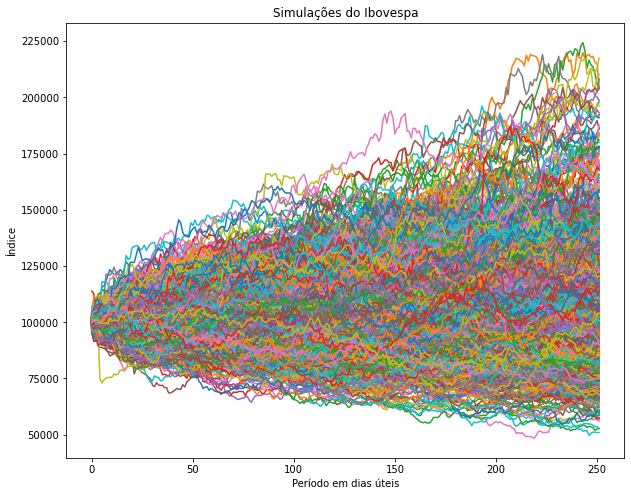

In [17]:
# Gerando matrizes aleatórias
simulacao = np.zeros((252,100000), dtype=np.float64)
for i in range(0,100000):
    simulacao[:,i] = t.rvs(df = param[0], loc = param[1], scale = param[2], size = 252)

# Construindo simulações
simulacao = pd.DataFrame(simulacao)
inicial = ibov.Close.tail(1)
simulacao.iloc[0] = inicial.iloc[0]*(1+simulacao.iloc[0])
for i in range(1,len(simulacao)):
    simulacao
    j = i-1
    simulacao.iloc[i] = simulacao.iloc[j]*(1+simulacao.iloc[i])

# Plotando gráfico das 1000 primeiras simulações
fig = plt.figure(figsize = (10,8))
plt.plot(simulacao.iloc[:,0:1000])
plt.title('Simulações do Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Período em dias úteis')
plt.show

## Construindo cenários
Para construir os cenários, coletamos os percentis de cada dia de todas as simulações. Os percentis mais baixos correspondem ao cenário pessimista, os percentis centrais, e também que abrangem maioria das simulações correspondem ao cenário moderado, e os maiores são os otimistas. Neste processo removemos os outliers, de modo que os intervalos não sejam tão abrangentes.

In [19]:
# Coletando cenários
sim_results = []
for i in range(0,len(simulacao)):
    min = np.percentile(simulacao.iloc[i], 10)
    pessim = np.percentile(simulacao.iloc[i], 20)
    lim1 = np.percentile(simulacao.iloc[i], 30)
    mod = np.percentile(simulacao.iloc[i], 50)
    lim2 = np.percentile(simulacao.iloc[i], 70)
    otim = np.percentile(simulacao.iloc[i], 80)
    sup = np.percentile(simulacao.iloc[i], 90)
    sim_results.append((min, pessim, lim1, mod, lim2, otim, sup))
sim_results = pd.DataFrame(sim_results)

# Sumarizando Dataframe
dados = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,0]))
for i in range(1,7):
    dados[i] = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,i]))
dados = dados.rename(columns={0:'Minimo', 1:"Pessimista", 2:"lim1", 
3:'Moderado', 4:'lim2', 5:"Otimista", 6:"Superior"})
dados = dados.reset_index(drop=True)

O cenário pessimista conta com 20% das simulações e localiza-se entre os percentis 10 e 30, neste cenário em um ano o índice se pode se localizar entre 77 mil e 93 mil. O cenário moderado, do qual possui 40% das simulações e ocupa os percentis centrais (entre 30 e 70) informa que em um ano o ibovespa pode registrar entre 93 e 120 mil. Já o cenário otimista, também com 20% das simulações, e ocupa os percentis mais altos (70 a 90) registra valores entre 120 e 144 mil pontos. Os 20% restantes das simulações faltantes são outliers descartadas da análise.

Portanto, o cenário mais provável de se concretizar é o moderado, e o otimista e pessimista tem iguais chances. Simariza-se os cenários graficamente a seguir.

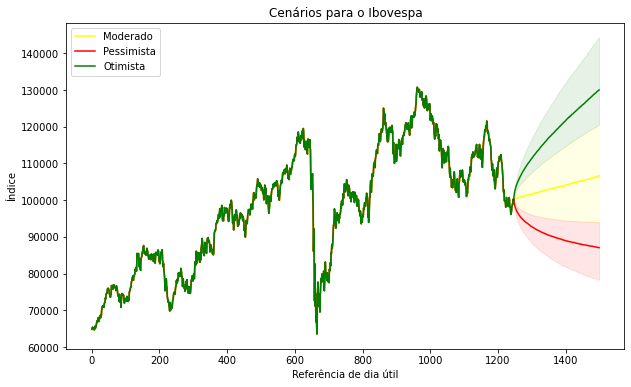

In [20]:
# Montando gráfico
graf = dados.iloc[(len(dados)-1500):len(dados),]
graf = graf.reset_index(drop=True)
graf = graf.reset_index()

fig, grf = plt.subplots(figsize=(10,6))
grf.plot(graf['index'], graf['Moderado'], color = 'yellow', label = 'Moderado')
grf.fill_between(graf['index'],graf['lim1'],graf['lim2'], color='yellow', alpha=.1)
grf.plot(graf['index'], graf['Pessimista'], color = 'red', label = 'Pessimista')
grf.fill_between(graf['index'],graf['Minimo'],graf['lim1'], color='red', alpha=.1)
grf.plot(graf['index'], graf['Otimista'], color = 'green', label = 'Otimista')
grf.fill_between(graf['index'],graf['lim2'],graf['Superior'], color='green', alpha=.1)
grf.set_title('Cenários para o Ibovespa')
grf.set_ylabel('Índice')
grf.set_xlabel('Referência de dia útil')
grf.legend(loc = 'upper left')
plt.show()

## Análise de riscos
Uma vez de posse das simulações, podemos analisar os riscos. Aqui definimos risco como a probabilidade do índice estar abaixo do nível atual a determinado período. Então calculamos a diferença da simulação e da pontuação mais recente do índice.

In [21]:
# Base de dados do Risco
risco = simulacao
for i in range(0,len(risco)):
    risco.iloc[i] = risco.iloc[i] - inicial.iloc[0]

Mensuramos o risco ao final do período calculando relação entre simulações menores que zero e o total de simulações. Da base de dados associada ao risco, podemos construir um histograma para a visualização do risco.

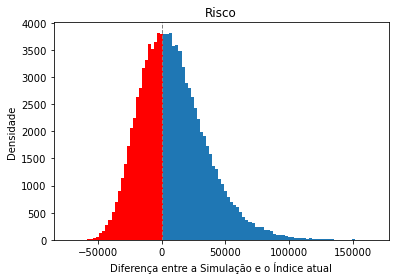

O risco no final do período é 40.041%


In [25]:
# Plotando gráfico
_, _, bars = plt.hist(risco.iloc[i], bins = 100, color="r")
for bar in bars:
    if bar.get_x() > 0:
        bar.set_facecolor("C0")
plt.xlabel("Diferença entre a Simulação e o Índice atual")
plt.ylabel("Densidade")
plt.title("Risco")
plt.axvline(x=0, linestyle='--',linewidth=1, color='grey')
plt.show()

#Calculando risco
print("O risco no final do período é " + str((sum(i < 0 for i in risco.iloc[i])/len(risco.iloc[i]))*100)+"%")

Portanto, ao longo de um ano, as chances do índice estar menor do que o registrado atualmente é de 40%. Outra pergunta que podemos fazer é como esse risco se comporta ao longo do tempo, então analisamos o risco associado a todo o período das simulações.

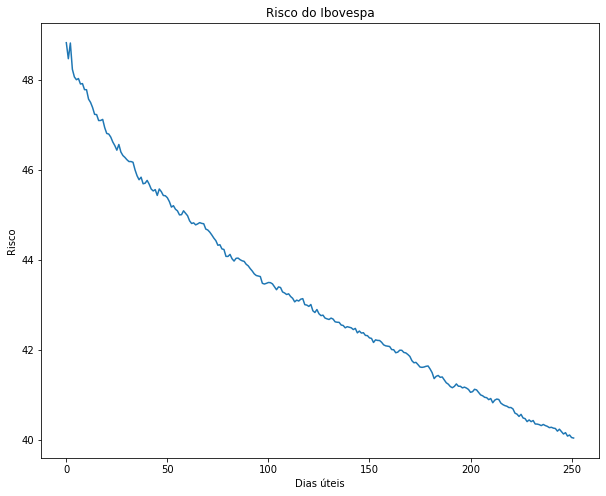

In [26]:
# Risco ao longo do tempo
rsct = []
for i in range(0,len(risco)):
    rsc = (sum(i < 0 for i in risco.iloc[i])/len(risco.iloc[i]))*100
    rsct.append(rsc)

# Plotando gráfico
rsct = pd.DataFrame(rsct)
rsct[0].plot(figsize = (10,8))
plt.title('Risco do Ibovespa')
plt.ylabel('Risco')
plt.xlabel('Dias úteis')
plt.show()

Deste modo, conseguimos observar que o risco do ibovespa ficar abaixo do nível atual reduz a medida que o tempo aumenta.

## Considerações Finais
Foi utilizado simulações de Monte Carlo para obter informações relevantes sobre o índice ibovespa e propiciar decisões de investimento melhor qualificadas. Na análise foi verificado que o cenário mais provável é que em um ano o ibovespa situe-se entre 93 e 120 mil pontos, há ainda cenários mais e menos favoráveis, mas com menor participação nas simulações.

O risco do ibovespa, ao final de 1 ano, registrar uma pontuação menor que a atual é de 40%, e foi verificado também que esse risco tende a diminuir a medida que aumenta a janela temporal, colaborando com a hipótese de que investimentos a longo prazos tem menores riscos.